# Score-PINN for $n$-Dimensional Fokker-Planck Equations

**Author:** Bilal Saleh Husain  

---

We implement the Score-PINN framework (Hu et al., 2024) for learning score functions $s(x,t) = \nabla_x \log p(x,t)$ in high-dimensional Fokker-Planck equations. Unlike standard PINNs that learn the density directly, Score-PINN learns the gradient of the log-density, which offers superior numerical stability. We validate against analytical solutions and demonstrate scalability to higher dimensions.

## Setup and Imports

In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent / 'src'))

from pinn_sgm.equations import FokkerPlanckMertonND
from pinn_sgm.nets import MLP, DGM
from pinn_sgm.solvers.score_pinn_solver import ScorePINNSolver
from pinn_sgm.config import ScorePINNConfig, TrainingConfig
from pinn_sgm.visualizations import (
    plot_training_history,
    plot_score_field,
    plot_score_mse,
    setup_publication_style
)

setup_publication_style()
%config InlineBackend.figure_format = 'retina'

In [2]:
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## Part 1: Mathematical Framework

### 1.1 Problem Formulation

**Geometric Brownian Motion**: Asset value $V_t$ follows:
$$
dV_t = \mu V_t dt + \sigma V_t dW_t
$$
where $\mu$ is the drift, $\sigma$ is the volatility, and $W_t$ is standard Brownian motion.

**Log-Space Transformation**: Transform to log-returns $X_t = \ln V_t$. By Itô's lemma:
$$
dX_t^{(i)} = \alpha_i dt + \sigma_i dW_t^{(i)}, \quad \alpha_i = \mu_i - \frac{\sigma_i^2}{2}
$$

In vector form: $dX_t = \alpha dt + \Sigma dW_t$ where $X_t \in \mathbb{R}^n$, $\alpha \in \mathbb{R}^n$, and $\Sigma \in \mathbb{R}^{n \times n}$.

**Fokker-Planck Equation**: The density $p(x, t)$ evolves as:
$$
\frac{\partial p}{\partial t} + \sum_{i=1}^n \alpha_i \frac{\partial p}{\partial x_i} - \frac{1}{2}\sum_{i,j=1}^n D_{ij} \frac{\partial^2 p}{\partial x_i \partial x_j} = 0
$$
where $D = \Sigma\Sigma^\top$.

**Initial condition**: $p(x, 0) = \delta(x - x_0)$  
**Analytical solution**: $p(x, t) = \mathcal{N}(x \mid x_0 + \alpha t, Dt)$  
**Score function**: $s(x, t) = \nabla_x \log p(x, t) = -\frac{1}{t}D^{-1}(x - x_0 - \alpha t)$

### 1.2 Score-PINN Method

**Score PDE** (Hu et al., 2024): For a general SDE $dX_t = f(X_t, t) dt + G(X_t, t) dW_t$, the score function satisfies:
$$
\frac{\partial s}{\partial t} = \nabla_x \left\{ \mathcal{L}[s(x,t)] \right\}, \quad x \in \mathbb{R}^d, t \in [0,T] 
$$
$$
s_0(x) = \nabla_x \log p_0(x), \quad x \in \mathbb{R}^d 
$$
where the operator $\mathcal{L}$ is defined as:
$$
\mathcal{L}[s] = \frac{1}{2}\nabla_x \cdot (GG^T s) + \frac{1}{2}s^T GG^T s - \langle A, s \rangle - \nabla_x \cdot A, \quad A = f - \frac{1}{2}\nabla_x \cdot (GG^T)
$$

**For Fokker-Planck with constant coefficients** ($f$ and $G$ are constant, $D = GG^T$):
- $A = f$ (since $\nabla \cdot D = 0$ for constant $D$)
- $\nabla \cdot A = 0$ (since $f$ is constant)

This simplifies to:
$$
\mathcal{L}[s] = \frac{1}{2}\nabla_x \cdot (D s) + \frac{1}{2}s^T D s - f^T s.
$$

## Part 2: Score-PINN Implementation

### 2.1 Equation Configuration

We configure an $n$-dimensional Fokker-Planck equation. The dimension `spatial_dim` can be adjusted to test scalability.

In [3]:
# --- Model parameters ---
spatial_dim = 2
mu = np.linspace(0.1, 0.05, spatial_dim)      # Drift: 10% to 5%
sigma = np.linspace(0.3, 0.2, spatial_dim)    # Volatility: 30% to 20%
x0 = np.zeros(spatial_dim)

# --- Domain ---
x_min, x_max = -2.0, 2.0
t_max = 1.0

# --- Equation ---
equation = FokkerPlanckMertonND(
    spatial_dim=spatial_dim,
    mu=mu,
    sigma=sigma,
    x0=x0,
    device=device
)

# --- Display ---
print(f"Configuration:")
print(f"  Dimension: {spatial_dim}D")
print(f"  Drift μ: {mu}")
print(f"  Diffusion σ: {sigma}")
print(f"  Domain: x ∈ [{x_min}, {x_max}]^{spatial_dim}, t ∈ [0, {t_max}]")
print(f"\nDiffusion matrix D = (1/2)ΣΣᵀ:")
print(equation.D.cpu().numpy())

Configuration:
  Dimension: 2D
  Drift μ: [0.1  0.05]
  Diffusion σ: [0.3 0.2]
  Domain: x ∈ [-2.0, 2.0]^2, t ∈ [0, 1.0]

Diffusion matrix D = (1/2)ΣΣᵀ:
[[0.09 0.  ]
 [0.   0.04]]


### 2.2 Score-PINN Architecture & Loss Function

The network approximates the score function $s(x, t)$:
- **Input**: Concatenated $[x_1, \ldots, x_n, t] \in \mathbb{R}^{n+1}$
- **Architectures**: 
  - MLP: Standard multi-layer perceptron with $\tanh$ activations
  - DGM: Deep Galerkin Method with LSTM-like gating (recommended for $d > 10$)
- **Output**: Score vector $s \in \mathbb{R}^n$ (no output activation, can be positive or negative)

**Loss Function**:
$$
\mathcal{L}(\theta) = \lambda_{\text{IC}} \mathcal{L}_{\text{IC}} + \lambda_{\text{PDE}} \mathcal{L}_{\text{PDE}}
$$
where
$$
\mathcal{L}_{\text{IC}} = \frac{1}{N_{\text{IC}}} \sum_{i} \left\|s_\theta(x_i, t_0) - s_{0}(x_i)\right\|^2, \quad \mathcal{L}_{\text{PDE}} = \frac{1}{N_{\text{col}}} \sum_{j} \left\|\frac{\partial s_\theta}{\partial t} - \nabla_x\{\mathcal{L}[s_\theta]\}\right\|^2
$$

Note: the IC loss only requires knowing the score at $t=t_0$, i.e., $s_{\text{true}}(x, t_0) = \nabla_x \log p(x, t_0)$. 

**Hutchinson Trace Estimation** (HTE): For computing the divergence $\nabla_x \cdot s = \text{tr}(J_s)$ where $J_s = \frac{\partial s}{\partial x}$ is the Jacobian, we use:
$$
\text{tr}(J_s) \approx \mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)}\left[\epsilon^\top J_s \epsilon\right] = \mathbb{E}_{\epsilon}\left[\epsilon^\top \frac{\partial s}{\partial x}\epsilon\right]
$$
This reduces the  gradient computation cost from $O(d)$ to $O(1)$.

In [4]:
# Option 1: MLP for score network (standard)
score_network = MLP(
    input_dim=spatial_dim + 1,  # Concatenated [x, t]
    output_dim=spatial_dim,     # Score vector
    hidden_dims=[64,64,64],
    activation='tanh'
).to(device)

'''
# Option 2: DGM for score network (for high dimensions)
score_network = DGM(
    input_dim=spatial_dim + 1,  # Concatenated [x, t]
    output_dim=spatial_dim,     # Score vector
    hidden_dims=[25,25,25],
    activation='tanh'
).to(device)
'''

n_params = sum(p.numel() for p in score_network.parameters())
print(f"Network: {score_network}")
print(f"Parameters: {n_params:,}")

Network: MLP(3 → 64 → 64 → 64 → 2, activation=tanh)
Parameters: 8,706


In [5]:
# --- Score-PINN config ---
score_config = ScorePINNConfig(
    n_collocation=5000,
    n_initial=2000,
    batch_size=256,
    lambda_initial=1.0,
    lambda_residual=1.0,
    x_range=(x_min, x_max),
    t_range=(0.0, t_max),
    method='score_pinn',  # try other ones?
    use_hte=True,         # Hutchinson Trace Estimation
    n_hte_samples=1
)

# --- Training config ---
training_config = TrainingConfig(
    epochs=10000,
    learning_rate=1e-3,
    lr_scheduler='step',
    lr_decay_step=2000,
    lr_decay_rate=0.9,
    optimizer='adam',
    gradient_clip_val=10.0,
    verbose=True,
    log_interval=500
)

# --- Solver ---
solver = ScorePINNSolver(
    equation=equation,
    score_network=score_network,
    config=score_config,
    device=device
)

n_params = sum(p.numel() for p in solver.score_network.parameters())
print(f"\nSolver Configuration:")
print(f"  Spatial domain: x ∈ {score_config.x_range}")
print(f"  Time domain: t ∈ {score_config.t_range}")
print(f"  Collocation points: PDE={score_config.n_collocation:,}, IC={score_config.n_initial:,}")
print(f"  Loss weights: λ_IC={score_config.lambda_initial}, λ_PDE={score_config.lambda_residual}")
print(f"  Using HTE: {score_config.use_hte}")
print(f"  Training: {training_config.epochs:,} epochs, LR={training_config.learning_rate}")


Solver Configuration:
  Spatial domain: x ∈ (-2.0, 2.0)
  Time domain: t ∈ (0.0, 1.0)
  Collocation points: PDE=5,000, IC=2,000
  Loss weights: λ_IC=1.0, λ_PDE=1.0
  Using HTE: True
  Training: 10,000 epochs, LR=0.001


### 2.3 Training

In [6]:
history = solver.train(training_config)


Epoch        Total        Initial      Residual     LR           Time        
------------------------------------------------------------------------
0/10000      5.0248e+04   5.0248e+04   5.0225e-03   1.0000e-03   15.47it/s   
500/10000    3.9007e+04   3.8968e+04   3.8487e+01   1.0000e-03   23.36it/s   
1000/10000   3.2615e+04   3.2554e+04   6.1549e+01   1.0000e-03   21.14it/s   
1500/10000   2.7334e+04   2.7237e+04   9.6988e+01   1.0000e-03   21.15it/s   
2000/10000   2.2084e+04   2.1980e+04   1.0398e+02   9.0000e-04   21.75it/s   
2500/10000   1.8679e+04   1.8541e+04   1.3818e+02   9.0000e-04   22.24it/s   
3000/10000   1.5011e+04   1.4856e+04   1.5494e+02   9.0000e-04   22.58it/s   
3500/10000   1.2364e+04   1.2171e+04   1.9313e+02   9.0000e-04   22.91it/s   
4000/10000   1.0811e+04   1.0496e+04   3.1480e+02   8.1000e-04   23.14it/s   
4500/10000   9.1927e+03   8.9554e+03   2.3733e+02   8.1000e-04   23.28it/s   
5000/10000   7.5351e+03   7.3917e+03   1.4339e+02   8.1000e-04   23.

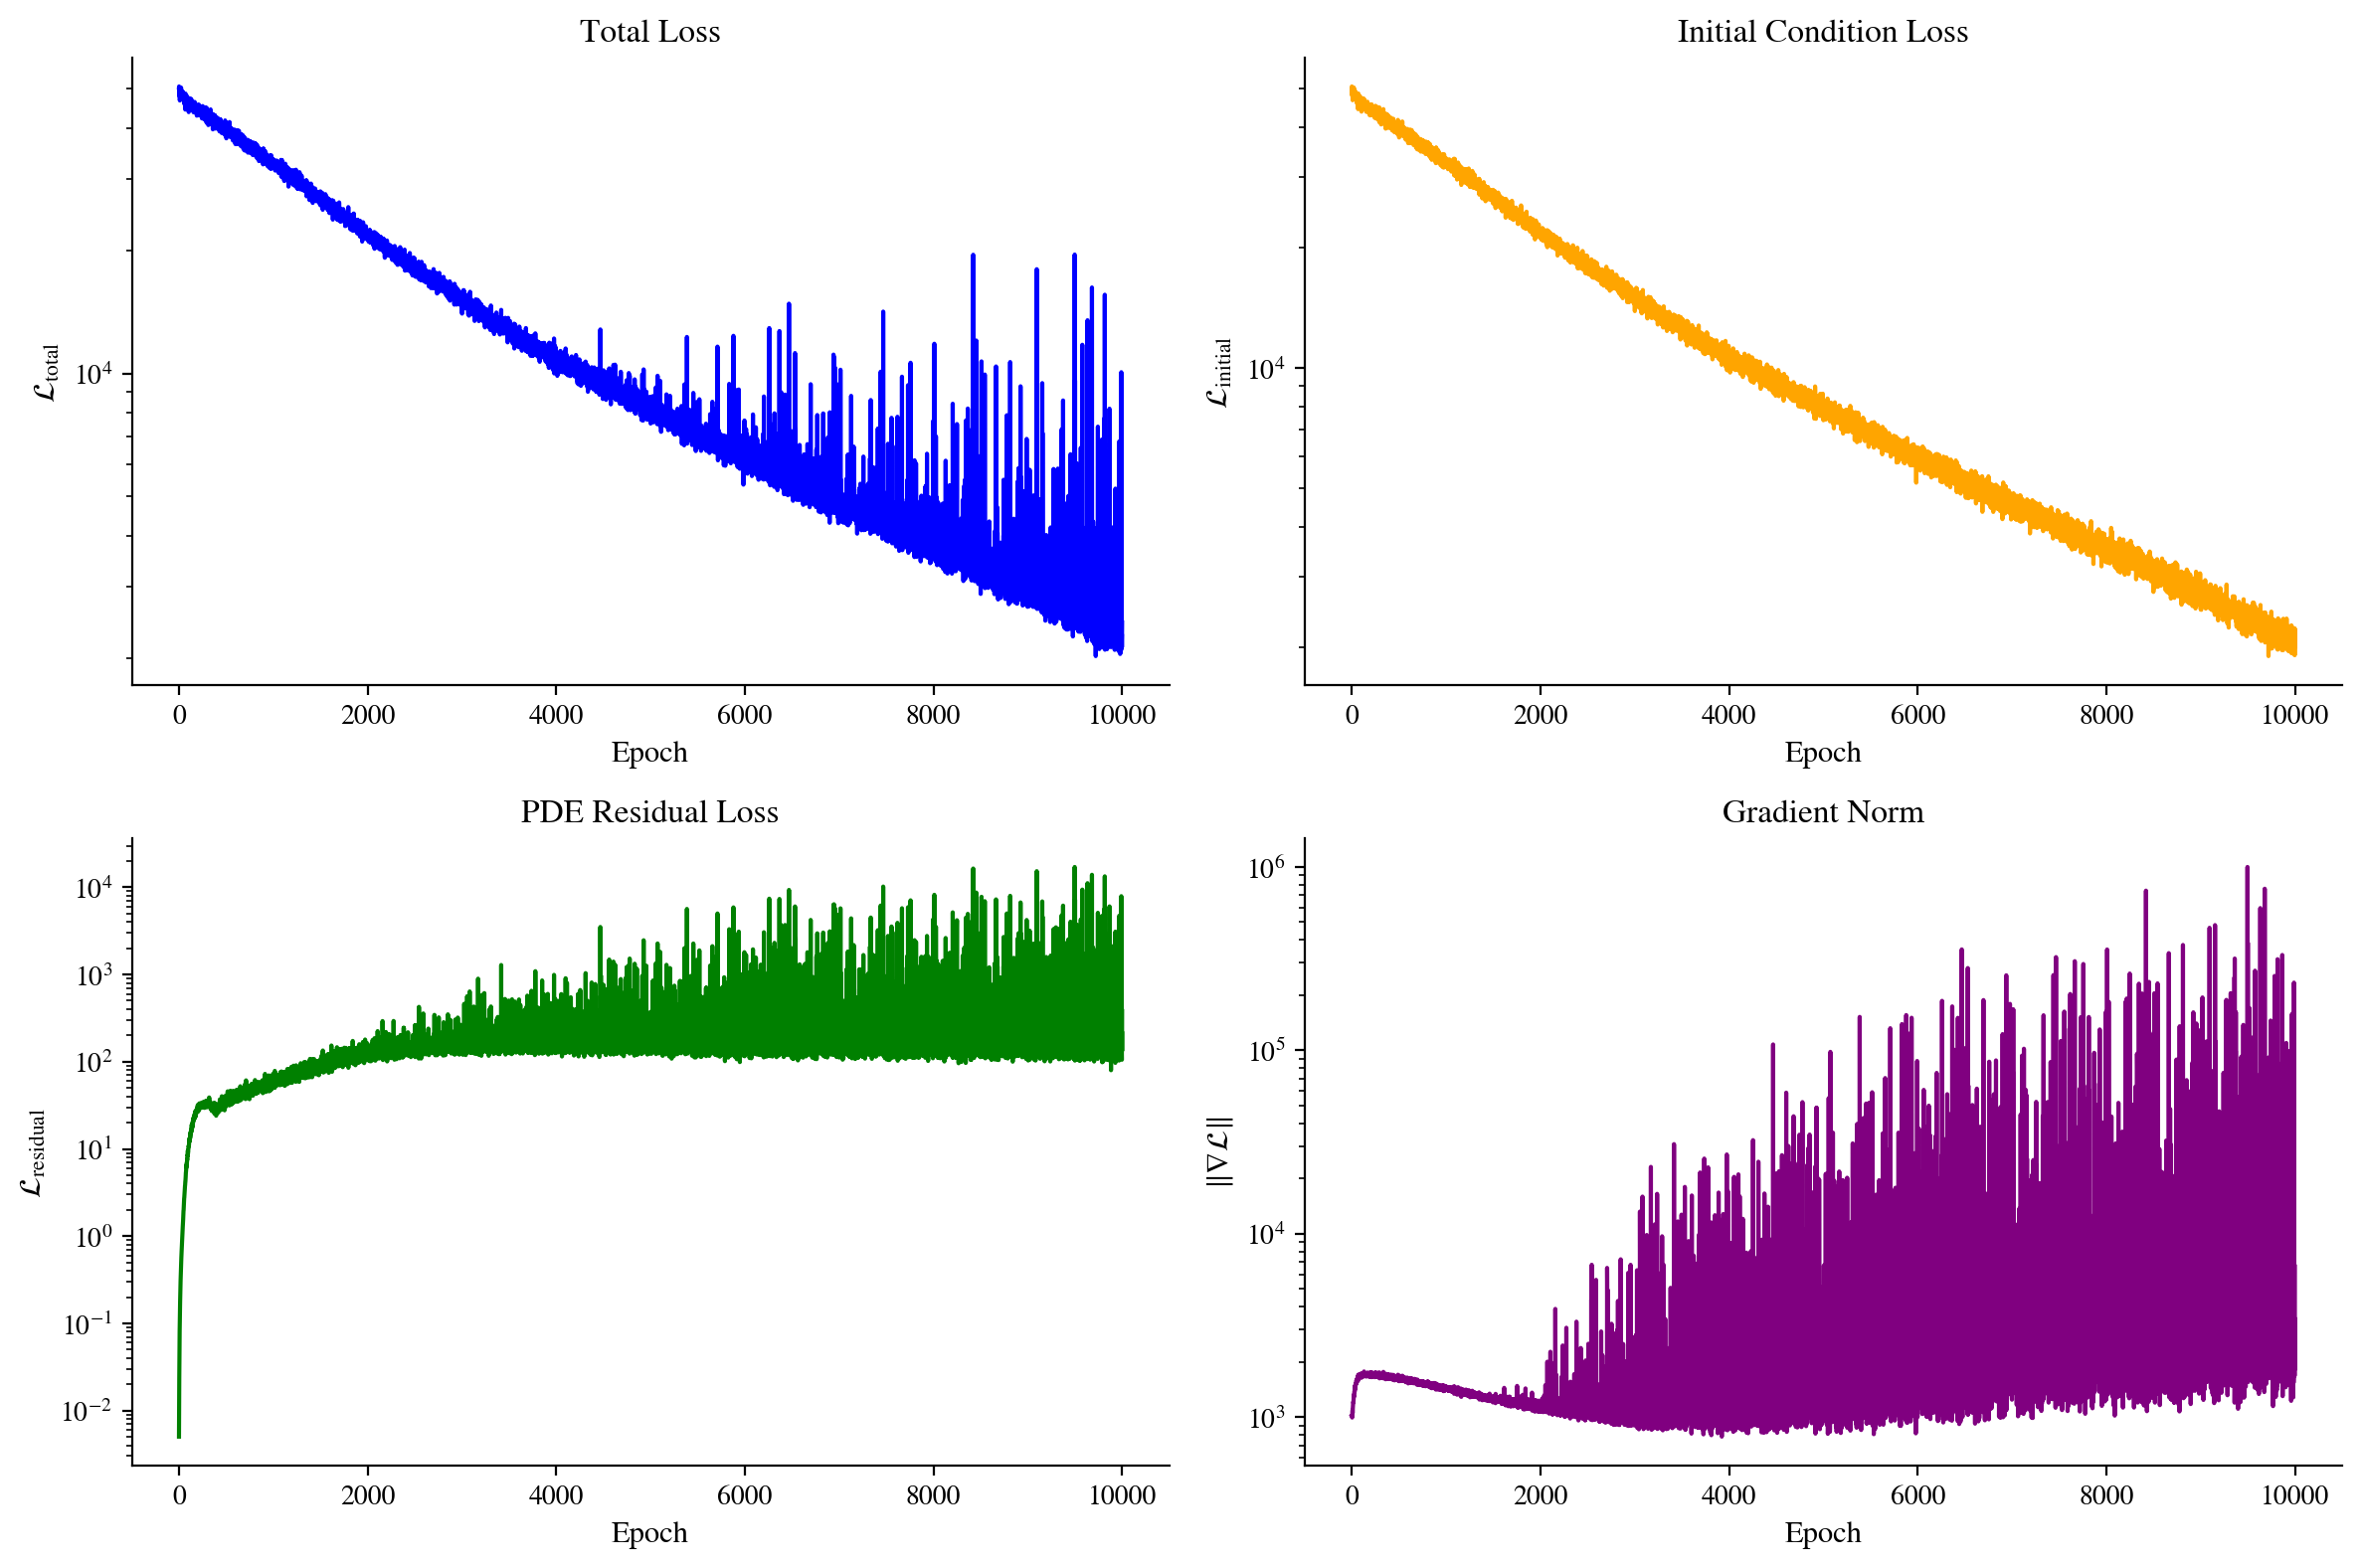


Final Losses:
  Total:    2.451512e+03
  Initial:  2.070212e+03
  Residual: 3.812998e+02


In [7]:
# Visualize training history
fig = plot_training_history(history, figsize=(12, 8))
plt.show()

print(f"\nFinal Losses:")
print(f"  Total:    {history['loss_total'][-1]:.6e}")
print(f"  Initial:  {history['loss_initial'][-1]:.6e}")
print(f"  Residual: {history['loss_residual'][-1]:.6e}")

## Part 3: Results & Validation

### 3.1 Score Field Evolution

We visualize the learned score function $s(x,t)$ at multiple time points and compare with the analytical solution.

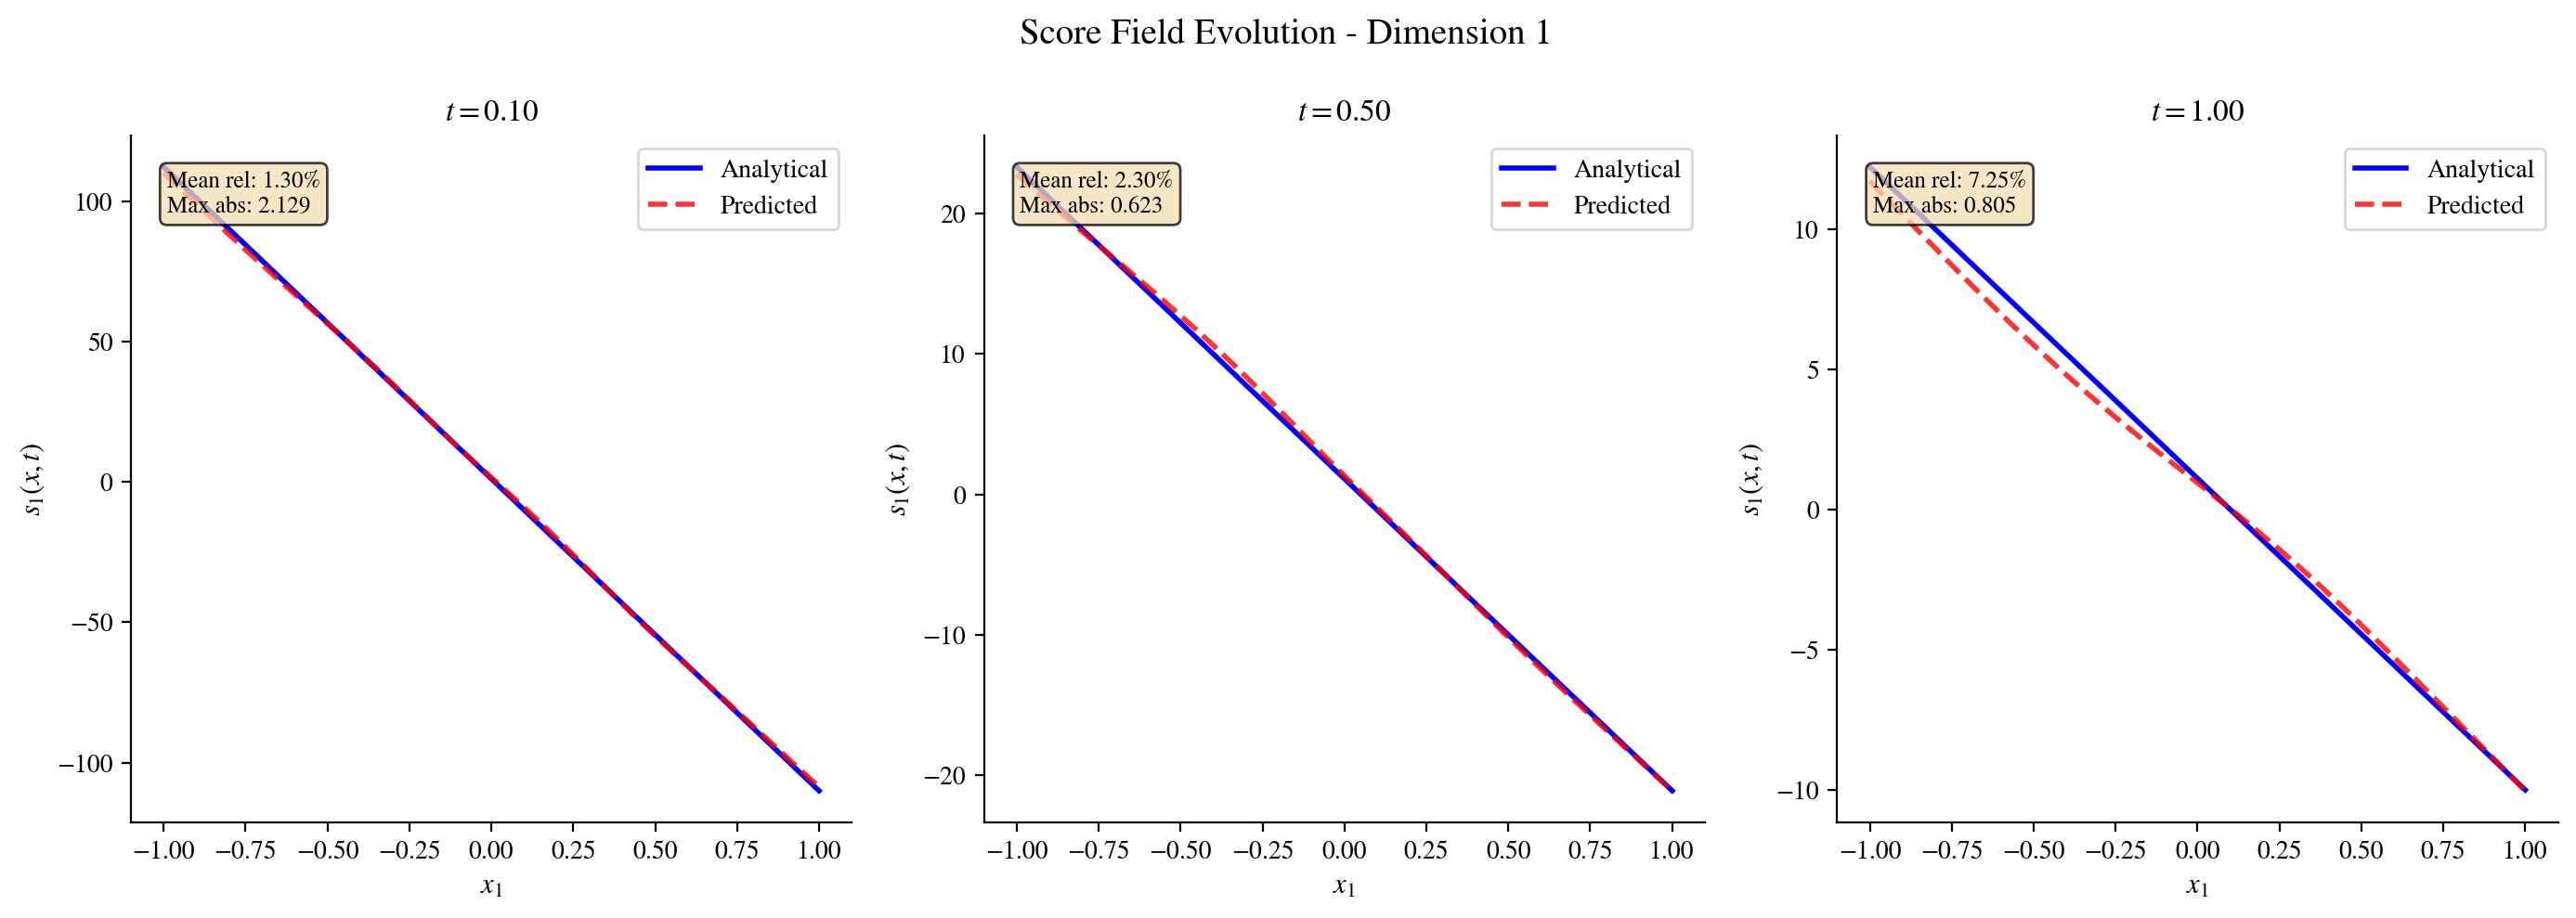

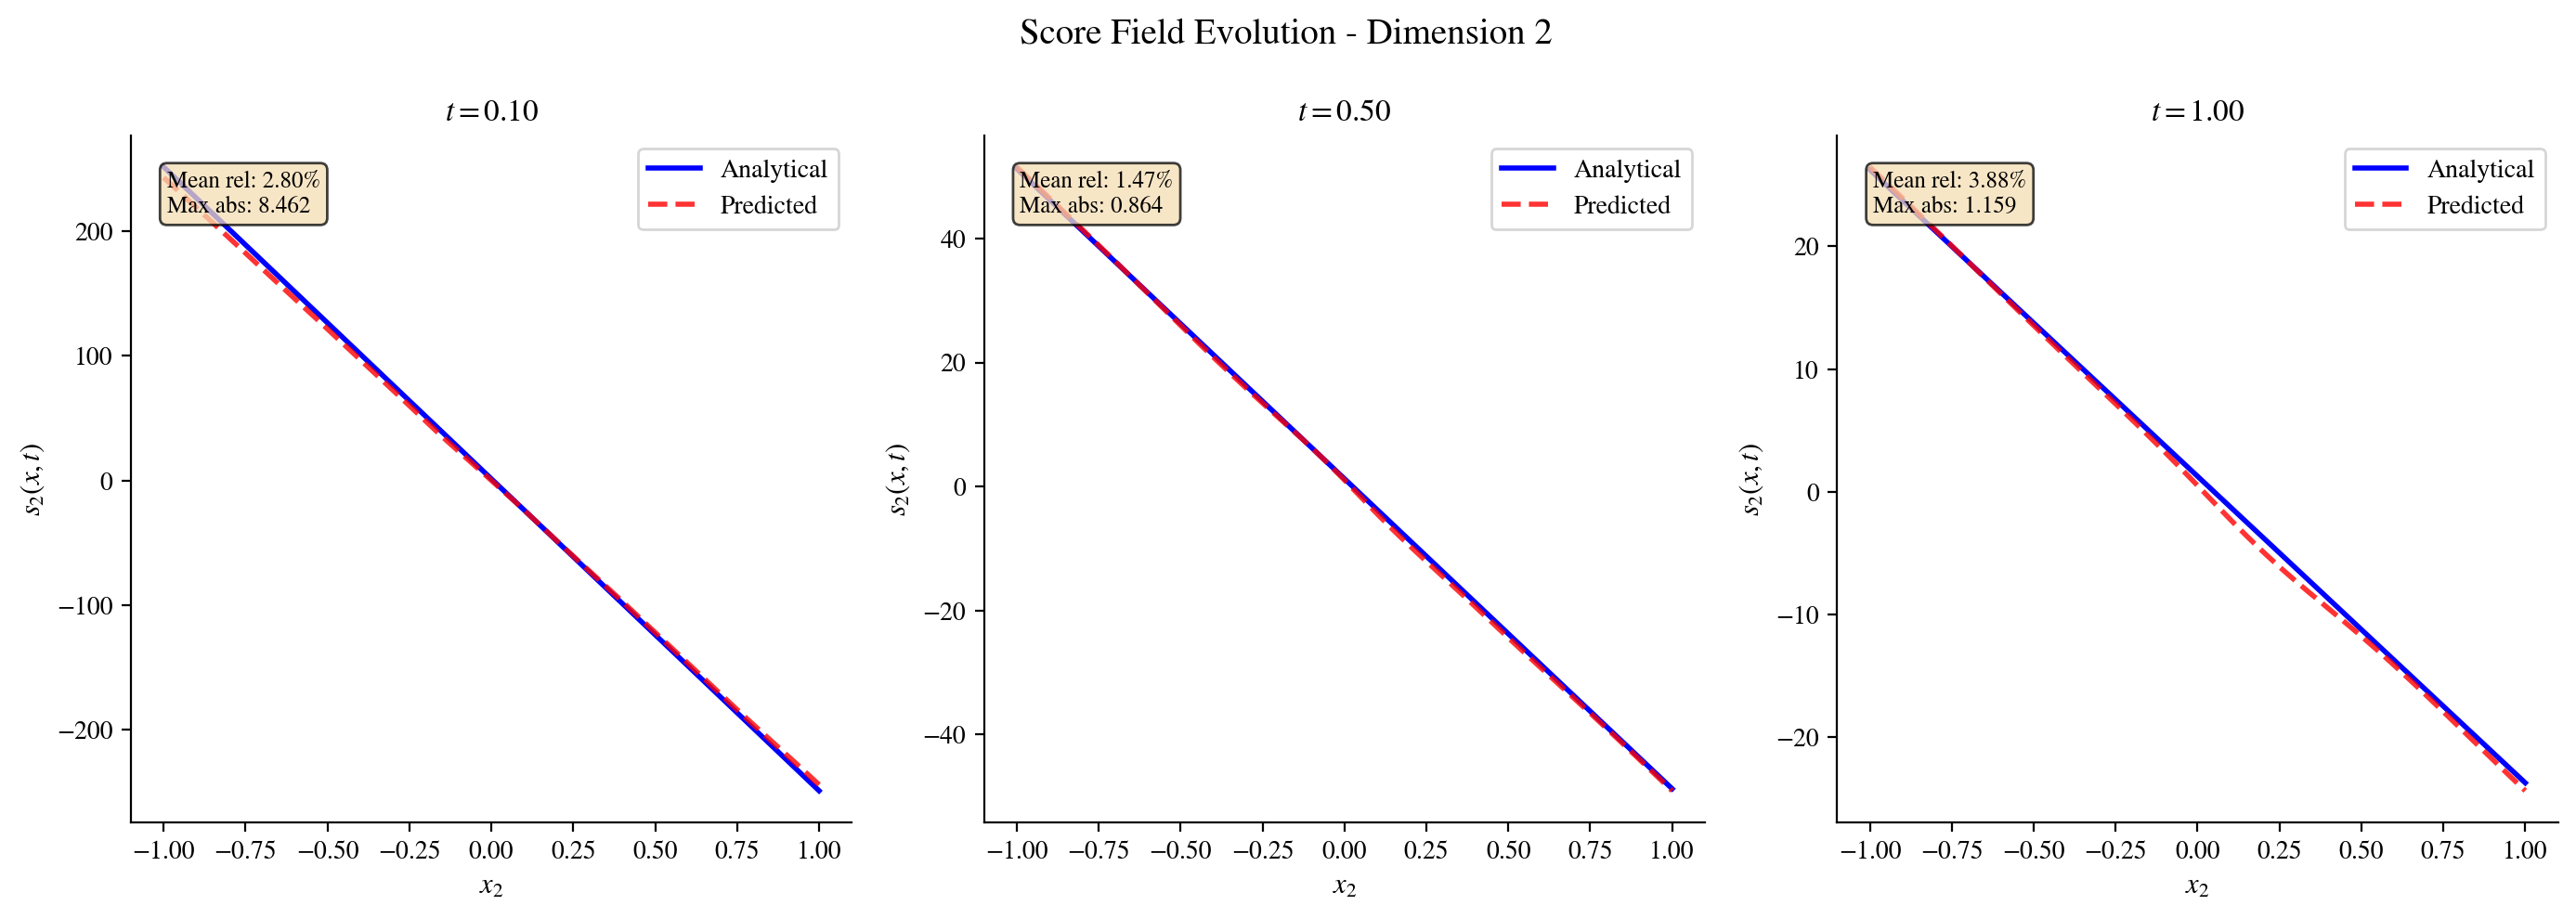

In [8]:
# --- Score field evolution ---
if spatial_dim == 1:
    # 1D: plot score as function of x
    fig = plot_score_field(
        solver=solver,
        equation=equation,
        x_range=(x_min, x_max),
        time_points=[0.1, 0.25, 0.5, 1.0],
        num_points=200,
        device=device,
        figsize=(14, 5)
    )
    plt.show()
else:
    # Multi-D: plot slices along each dimension
    for dim in range(spatial_dim):  
        fig = plot_score_field(
            solver=solver,
            equation=equation,
            x_range=(-1, 1),
            time_points=[0.1, 0.5, 1.0],
            dim=dim,
            fixed_values=None,
            num_points=200,
            device=device,
            figsize=(14, 5)
        )
        plt.suptitle(f'Score Field Evolution - Dimension {dim+1}', fontsize=14)
        plt.show()

### 3.2 Score MSE

We quantify score approximation quality via the mean squared error between the learned and analytical score fields, sampled uniformly over the spatial domain.

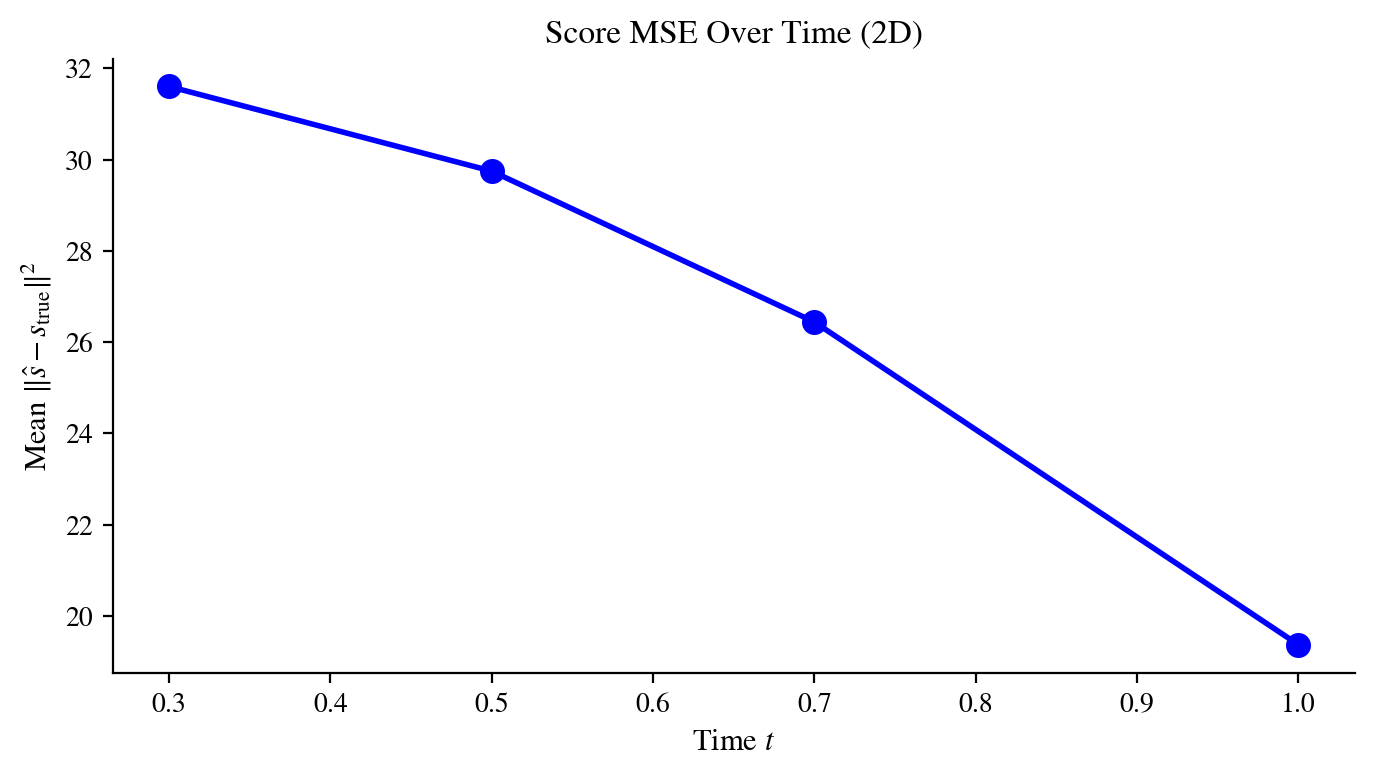

In [9]:
# Score MSE: E[||s_PINN - s_true||^2] over time
fig = plot_score_mse(
    solver=solver,
    equation=equation,
    eval_times=[0.3, 0.5, 0.7, 1.0],
    n_samples=2000,
    x_range=(-1, 1),
    device=device,
    figsize=(7, 4)
)
plt.show()

---

## References 

1. Hu, Z., Zhang, Z., Karniadakis, G. E., & Kawaguchi, K. (2024). Score-Based Physics-Informed Neural Networks for High-Dimensional Fokker-Planck Equations. *arXiv:2402.07465*. https://arxiv.org/pdf/2402.07465

2. Song, Y., Sohl-Dickstein, J., Kingma, D. P., Kumar, A., Ermon, S., & Poole, B. (2021). Score-based generative modeling through stochastic differential equations. *ICLR 2021*. https://arxiv.org/pdf/2011.13456